# Tensorflow Similarity Hello World

[FIXME intro blurb]

References
- Original paper:
FaceNet: A Unified Embedding for Face Recognition and Clustering
https://arxiv.org/abs/1503.03832 

- Mining strategies:
https://openaccess.thecvf.com/content_WACV_2020/papers/Xuan_Improved_Embeddings_with_Easy_Positive_Triplet_Mining_WACV_2020_paper.pdf 


In [1]:
 %load_ext autoreload
 %autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import  TensorBoard
# from tqdm.auto import tqdm
from time import  time
from tabulate import tabulate
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [3]:
from tensorflow_similarity.utils import tf_cap_memory
from tensorflow_similarity.losses import TripletLoss
from tensorflow_similarity.layers import MetricEmbedding
from tensorflow_similarity.model import SimilarityModel
from tensorflow_similarity.sampler import  MultiShotMemorySampler
from tensorflow_similarity.sampler import select_examples
from tensorflow_similarity.visualization import viz_neigbors_imgs

In [4]:
tf_cap_memory()
print(tf.__version__)

2.3.1


# Preparing data
To demonstrate the ability of single-shot learning, we are going to train a model on even digit only but create
an index that contains a few examples of both even and odd digits to show how the model is able to do matching on 
unseen classes with few examples.


Note: Tensorflow similarity expect y_train to be the examples class as integer so there is no need for processing

In [41]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = tf.constant(x_train / 255.0, dtype='float32')
x_test = tf.constant(x_test / 255.0, dtype='float32')

x_restricted, y_restricted = select_examples(x_train, y_train, [1,3,5,7,9], 10000)
print(x_restricted.shape, y_restricted.shape)

(30000, 28, 28) (30000,)


In [74]:
BATCH_SIZE = 16 #@param{Integer}
CLASS_PER_BATCH = 8
sampler = MultiShotMemorySampler(x_restricted, y_restricted, class_per_batch=CLASS_PER_BATCH, batch_size=BATCH_SIZE)

# model creation

In [78]:
def get_model():
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(28,28))
    x = layers.Reshape((28,28,1))(inputs)
    x = layers.Conv2D(16, 3, activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = MetricEmbedding(10)(x)
    # outputs2 = MetricEmbedding(10)(x)
    return SimilarityModel(inputs, outputs)
model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7744)         

# Loss definition

Overall Similarity losses (aka metric losses) are similar to other losses except they expect different inputs.

For triplet loss, one of the most popular one, you need to decide what type of triplet mining you want. Usually `hard` mining for positive example and `semi-hard` mining work well and are the default. They are passed explicitly here for reference.

The `distance` parameters specify which distance metric to use to compute the distance between embeddings. `cosine` is usually a great starting point and the default.


In [79]:
distance = 'cosine' #@param ["cosine"]{allow-input: false}
positive_mining_strategy = 'hard' #@param ["easy", "hard"]{allow-input: false}
negative_mining_strategy = 'semi-hard' #@param ["easy", "hard"]{allow-input: false}
triplet_loss = TripletLoss(distance=distance,
    positive_mining_strategy=positive_mining_strategy,
    negative_mining_strategy=negative_mining_strategy)

# Compilation

Tensorflow similarity use an extended `compile()` method that allows you to specify distance_metrics (metrics that are computed over the distance between the embedding). 

By default the `compile()` method try to infers what type of distance you are using by looking at the fist loss specified. If you use multiples losses and the distance loss is not the first, then you need to specify the distance function used as `distance=` parameter in the compile function.

In [80]:
model = get_model()
model.compile(optimizer='adam', loss=triplet_loss)

# Training

Similarity are trained like normal model. Don't expect the validation loss to decrease too much because we only use half of the class on the train data but all class in the validation.

In [81]:
EPOCHS = 5 #@param{Integer}
history = model.fit(sampler, validation_data=(x_test, y_test), batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
1000/1000 [==============================] - 17s 17ms/step - loss: 0.2314 - val_loss: 0.6460
Epoch 2/5
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1388 - val_loss: 0.6314
Epoch 3/5
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1083 - val_loss: 0.6336
Epoch 4/5
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0960 - val_loss: 0.6684
Epoch 5/5
1000/1000 [==============================] - 17s 17ms/step - loss: 0.0959 - val_loss: 0.6490


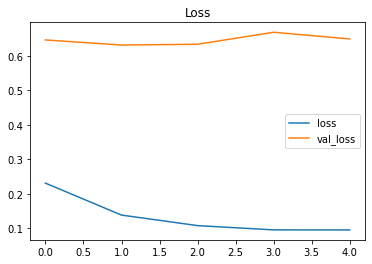

In [82]:
# let's visualizing loss overtime
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('Loss')
plt.show()

# Indexing

Indexing is where things get different from traditional classification models. Because the model learned to output an embedding that represent the example position in a metric space and not a classification, we need a way to find which known example(s) are the closest to determine the class of the incoming data (aka nearest neighboors classication).

To do so we need to create an index of known example from the 10 digits class. We do this by taking 50 examples from the train dataset which is 5 examples for each digit and use the `index()` funtion of the model to build the index.

In [87]:
x_index, y_index = select_examples(x_train, y_train, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 100)
model.index_reset()
model.index(x_index, y_index)

# Querying

To "classify" our testing data, we need for each testing example to look for its nearest neighbors in our index. We are going to query a single example from our test dataset using the `single_lookup()` function.

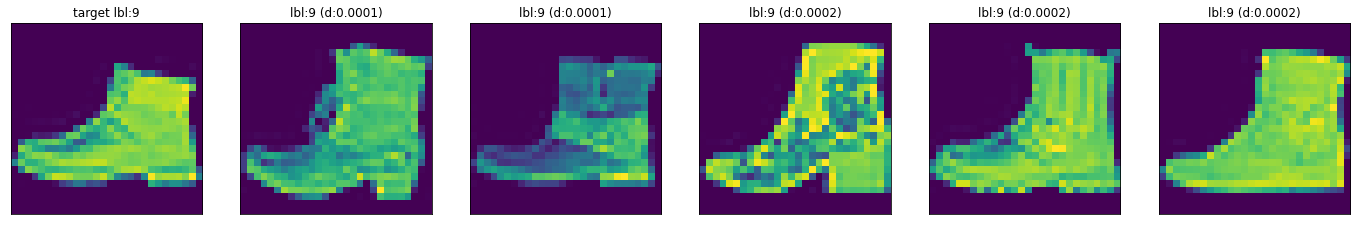

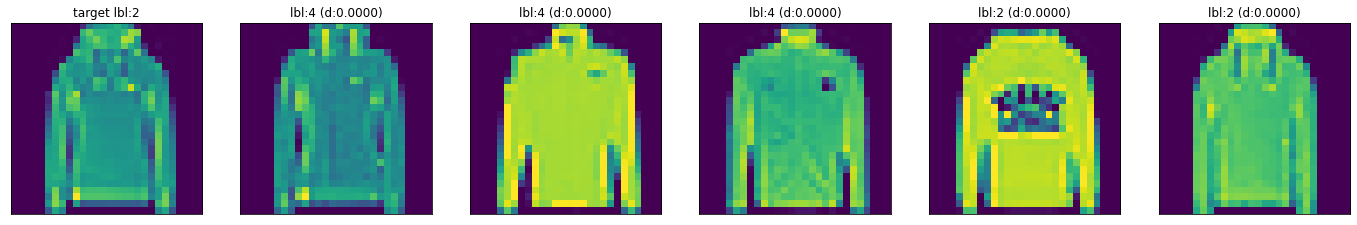

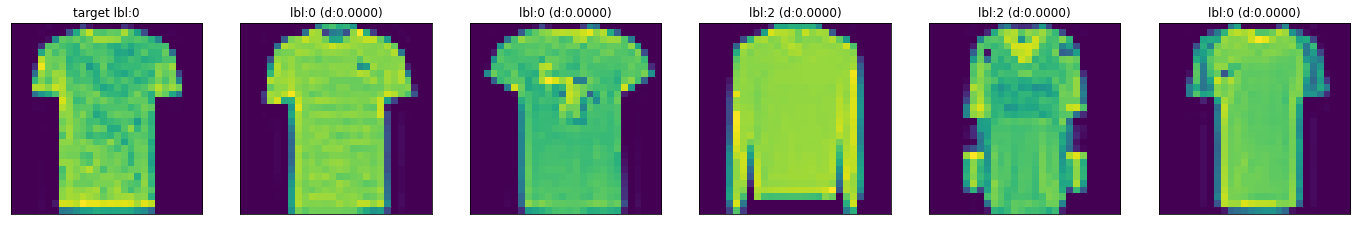

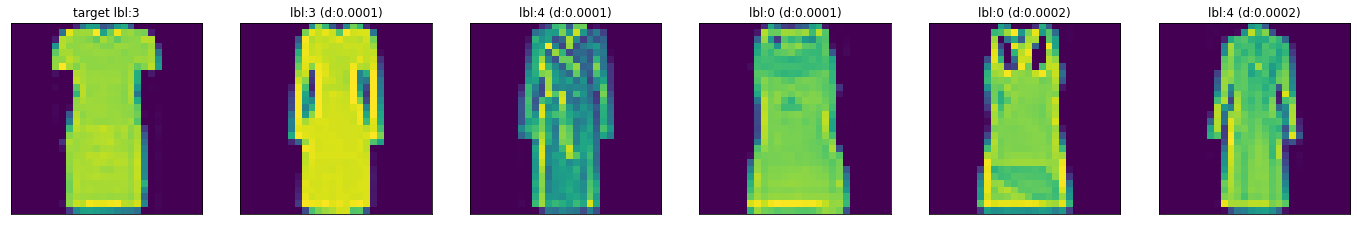

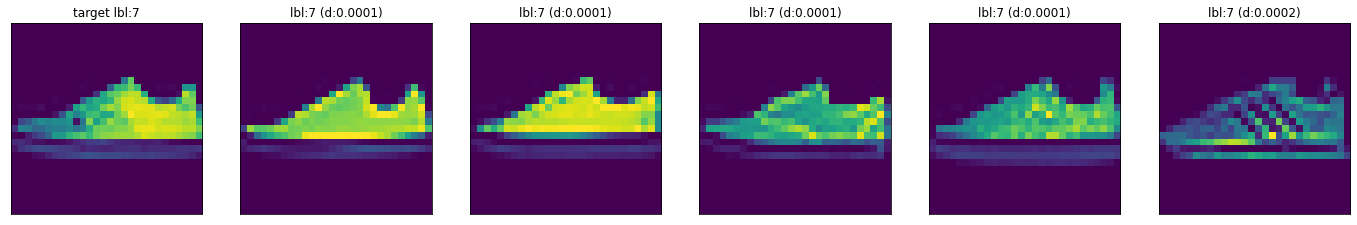

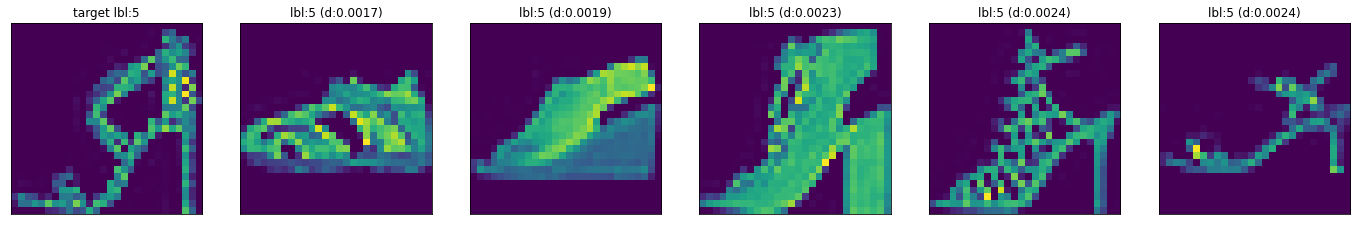

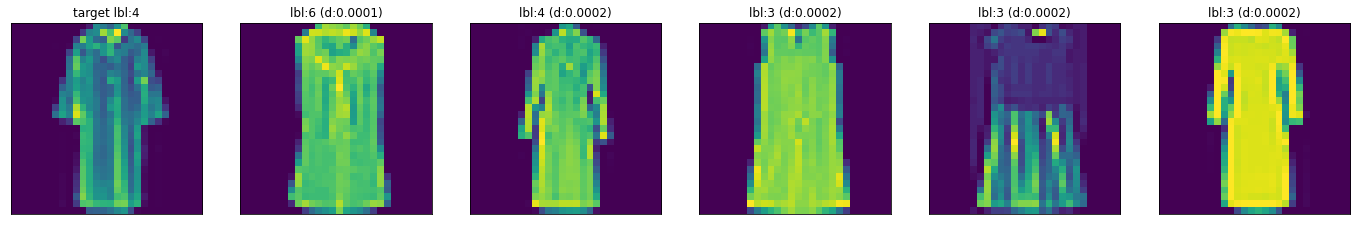

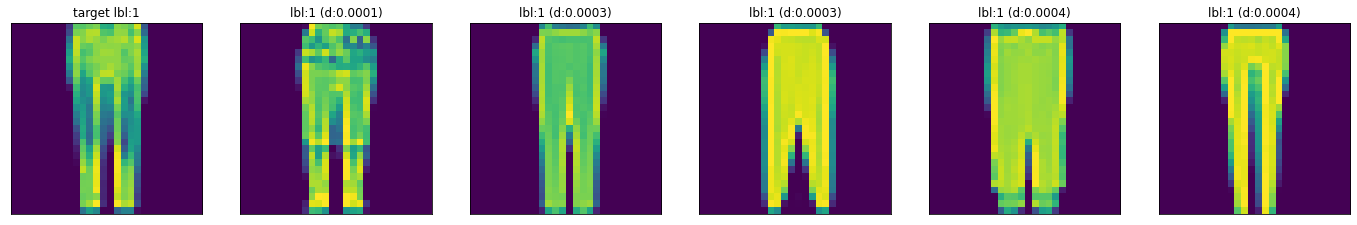

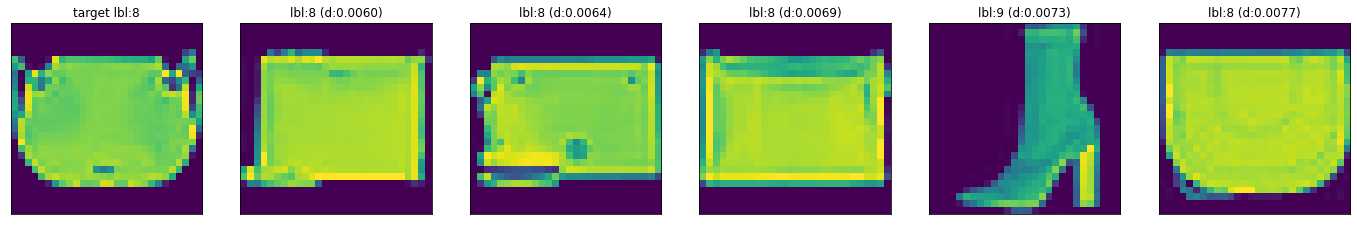

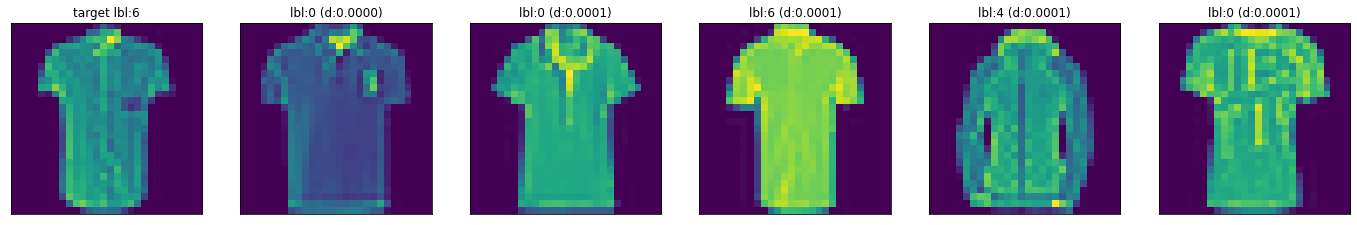

In [97]:
# query the closest points in our index for ALL 10000 test examples
num_neighboors = 5
x_display, y_display = select_examples(x_test, y_test, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1)


for idx in range(len(x_display)):
    # query closest matches
    neighboors = model.single_lookup(x_display[idx], k=num_neighboors)

    # view results close by
    viz_neigbors_imgs(x_display[idx], y_display[idx], neighboors)

# # display results in tabular format
# rows = [[n['label'], n['distance']] for n in neighboors]
# print('Expected label: %d' % y_test[test_id])
# print(tabulate(rows, headers=['label', 'distances']), '\n')



# Indexer stats

You can display the indexer performance summary using the `index_summary()` function.

In [59]:
model.index_summary()

[Index statistics]
----------------  ---
query_time          0
query               0
num_lookups         8
num_items          50
stat_buffer_size  100
----------------  ---

[Query performance]
------  -----------
min     0
max     0.000524521
avg     6.55651e-05
median  0
stddev  0.000173469
------  -----------


# matching

In [62]:
num_calibration_samples = 200
calibration = model.calibrate(x_train
[:num_calibration_samples], y_train[:num_calibration_samples], k=5, verbose=1)

num positive matches 577/1000


ZeroDivisionError: float division by zero

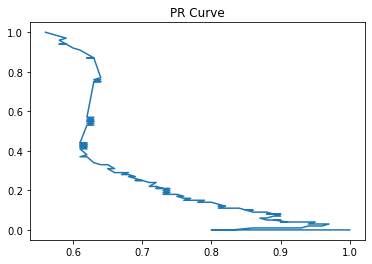

In [37]:
plt.plot(calibration['thresholds']['precision'], calibration['thresholds']['recall'])
plt.title("PR Curve")
plt.show()

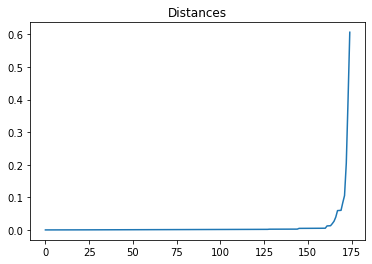

In [38]:
plt.plot(calibration['thresholds']['distance'])
plt.title("Distances")
plt.show()

In [39]:
rows = []
thresholds = calibration['thresholds']
for idx in range(len(thresholds['distance'])):
    rows.append([thresholds['distance'][idx], thresholds['f1'][idx], thresholds['precision'][idx], thresholds['recall'][idx]])

print(tabulate(rows, headers=['distance', 'f1', 'precision', 'recall']))

   distance          f1    precision    recall
-----------  ----------  -----------  --------
4.02331e-05  0.00715564         1         0
6.52075e-05  0.00714924         0.8       0
6.62208e-05  0.00892857         0.83      0
6.74129e-05  0.0107047          0.86      0.01
8.03471e-05  0.0124777          0.88      0.01
8.96454e-05  0.0142476          0.89      0.01
9.05395e-05  0.0160142          0.9       0.01
9.23872e-05  0.0177778          0.91      0.01
0.000112593  0.0212955          0.92      0.01
0.000121474  0.0248007          0.93      0.01
0.000125766  0.0300353          0.94      0.02
0.000141501  0.0369718          0.95      0.02
0.000163436  0.0472855          0.96      0.02
0.000172079  0.0557977          0.97      0.03
0.000176311  0.0591304          0.94      0.03
0.000203967  0.0708729          0.95      0.04
0.000209272  0.0724763          0.93      0.04
0.000216186  0.0740741          0.91      0.04
0.000235975  0.0806867          0.92      0.04
0.000236273  0.0806175